# Post training analysis

In [1]:
import random
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, precision_score, recall_score, confusion_matrix, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("D:/AI/Case_Studies/Personal_Case_Study_1/Data/Processed/final_train_data.csv")
X =  df.drop(['Provider', 'PotentialFraud'], axis=1)
Y = df['PotentialFraud'].values
print(X.shape)
print(Y.shape)

(5410, 33)
(5410,)


In [3]:
# Scaling data
s = StandardScaler()
X_scaled = s.fit_transform(X)

In [2]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model in models:
        res_x.append(model.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

In [5]:
# Loading base learners
files = os.listdir('D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/base_learners')
models = []
for model in files:
    clf = load('D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/base_learners/'+model)
    models.append(clf)

In [6]:
# Loading custom model
stacked_clf = load('D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/best_custom_model.joblib')
stacked_clf

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [7]:
# Predictions on data
meta_data = generate_data(X_scaled, models)
y_pred = stacked_clf.predict(meta_data)
# Probability of x belonging to +ve class
y_prob = stacked_clf.predict_proba(meta_data)[:, 1]

In [8]:
# Dataframe with all predictions
all_predictions = pd.DataFrame(X_scaled)
all_predictions['Actual_Y'] = Y
all_predictions['Predicted_Y'] = y_pred
all_predictions['Predicted_Probability'] = y_prob
print(all_predictions.shape)
all_predictions.head()

(5410, 36)


0         1         2         3         4         5         6  \
0 -0.302331 -0.286976 -0.233798 -0.242580 -0.264180 -0.231837 -0.255574   
1  0.349223  0.105783  0.165219  0.133225  0.120232  0.195288 -0.135249   
2  0.496349  0.168184  0.051214  0.206553  0.170647  0.068059  0.009141   
3  2.997478  3.897558  4.535405  3.524633  3.901341  4.221171  3.594821   
4 -0.064129 -0.114456 -0.176795 -0.141754 -0.131841 -0.186398 -0.087119   

          7         8         9  ...        26        27        28        29  \
0 -0.268695 -0.305090 -0.271258  ...  1.069562  0.082069  1.152016  0.084346   
1  0.105019  0.077719  0.142568  ... -0.782405  0.812169  0.006929 -0.212702   
2  0.105019  0.154281  0.168759  ... -0.303008 -0.430554 -0.222386  0.101508   
3  3.167060  3.744176  3.804141  ... -0.687371 -0.430554 -0.229902  0.080687   
4 -0.196363 -0.134952 -0.124585  ... -0.943976 -0.316638 -0.420597 -0.223465   

         30        31        32  Actual_Y  Predicted_Y  Predicted_Probability  
0 -0.120048  0.048681 -0.278969         0            0               0.108000  
1  1.066796  1.037938  0.806916         1            1               0.945679  
2 -0.476743 -0.438565 -0.284057         0            0               0.122459  
3 -0.473878 -0.438565 -0.449847         1            1               0.945679  
4 -0.243879 -0.382171 -0.513068         0            0               0.122459  

[5 rows x 36 columns]

In [9]:
# Add feature names
cols = {i: df.columns[i+1] for i in range(33)}
all_predictions.rename(columns=cols, inplace=True)
all_predictions.head()

Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
0            -0.302331     -0.286976              -0.233798   
1             0.349223      0.105783               0.165219   
2             0.496349      0.168184               0.051214   
3             2.997478      3.897558               4.535405   
4            -0.064129     -0.114456              -0.176795   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0              -0.242580                 -0.264180                  -0.231837   
1               0.133225                  0.120232                   0.195288   
2               0.206553                  0.170647                   0.068059   
3               3.524633                  3.901341                   4.221171   
4              -0.141754                 -0.131841                  -0.186398   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  \
0           -0.255574                   -0.268695               -0.305090   
1           -0.135249                    0.105019                0.077719   
2            0.009141                    0.105019                0.154281   
3            3.594821                    3.167060                3.744176   
4           -0.087119                   -0.196363               -0.134952   

   ChronicCond_Diabetes  ...       Age  Days_Admitted  Diseases_Count  \
0             -0.271258  ...  1.069562       0.082069        1.152016   
1              0.142568  ... -0.782405       0.812169        0.006929   
2              0.168759  ... -0.303008      -0.430554       -0.222386   
3              3.804141  ... -0.687371      -0.430554       -0.229902   
4             -0.124585  ... -0.943976      -0.316638       -0.420597   

   Total_Physicians  Total_ClaimCodes  Total_ProcedureCodes  Claim_Period  \
0          0.084346         -0.120048              0.048681     -0.278969   
1         -0.212702          1.066796              1.037938      0.806916   
2          0.101508         -0.476743             -0.438565     -0.284057   
3          0.080687         -0.473878             -0.438565     -0.449847   
4         -0.223465         -0.243879             -0.382171     -0.513068   

   Actual_Y  Predicted_Y  Predicted_Probability  
0         0            0               0.108000  
1         1            1               0.945679  
2         0            0               0.122459  
3         1            1               0.945679  
4         0            0               0.122459  

[5 rows x 36 columns]

In [10]:
correct_pred = all_predictions[all_predictions['Actual_Y'] == all_predictions['Predicted_Y']]
print("Total correct predictions: ", len(correct_pred))
wrong_pred = all_predictions[all_predictions['Actual_Y'] != all_predictions['Predicted_Y']]
print("Total incorrect predictions: ", len(wrong_pred))

Total correct predictions:  4992
Total incorrect predictions:  418


In [11]:
correct_pred.head()

Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
0            -0.302331     -0.286976              -0.233798   
1             0.349223      0.105783               0.165219   
2             0.496349      0.168184               0.051214   
3             2.997478      3.897558               4.535405   
4            -0.064129     -0.114456              -0.176795   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0              -0.242580                 -0.264180                  -0.231837   
1               0.133225                  0.120232                   0.195288   
2               0.206553                  0.170647                   0.068059   
3               3.524633                  3.901341                   4.221171   
4              -0.141754                 -0.131841                  -0.186398   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  \
0           -0.255574                   -0.268695               -0.305090   
1           -0.135249                    0.105019                0.077719   
2            0.009141                    0.105019                0.154281   
3            3.594821                    3.167060                3.744176   
4           -0.087119                   -0.196363               -0.134952   

   ChronicCond_Diabetes  ...       Age  Days_Admitted  Diseases_Count  \
0             -0.271258  ...  1.069562       0.082069        1.152016   
1              0.142568  ... -0.782405       0.812169        0.006929   
2              0.168759  ... -0.303008      -0.430554       -0.222386   
3              3.804141  ... -0.687371      -0.430554       -0.229902   
4             -0.124585  ... -0.943976      -0.316638       -0.420597   

   Total_Physicians  Total_ClaimCodes  Total_ProcedureCodes  Claim_Period  \
0          0.084346         -0.120048              0.048681     -0.278969   
1         -0.212702          1.066796              1.037938      0.806916   
2          0.101508         -0.476743             -0.438565     -0.284057   
3          0.080687         -0.473878             -0.438565     -0.449847   
4         -0.223465         -0.243879             -0.382171     -0.513068   

   Actual_Y  Predicted_Y  Predicted_Probability  
0         0            0               0.108000  
1         1            1               0.945679  
2         0            0               0.122459  
3         1            1               0.945679  
4         0            0               0.122459  

[5 rows x 36 columns]

In [12]:
wrong_pred.head()

Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
20             0.545390      0.248938               0.507234   
21             0.629462      0.300327               0.355227   
26             0.279164      0.138819               0.222222   
37            -0.211254     -0.209892              -0.214797   
52            -0.127182     -0.165845              -0.138794   

    ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
20               0.289046                  0.315590   
21               0.444868                  0.422721   
26               0.261549                  0.170647   
37              -0.242580                 -0.201162   
52              -0.224248                 -0.150747   

    ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
20                   0.349780            0.346051                    0.394346   
21                   0.422482            0.081336                    0.466678   
26                   0.204376            0.273856                    0.129130   
37                  -0.222750           -0.231509                   -0.244584   
52                  -0.159135           -0.087119                   -0.220473   

    ChronicCond_Depression  ChronicCond_Diabetes  ...       Age  \
20                0.264870              0.273526  ... -0.294154   
21                0.307404              0.299717  ... -0.127772   
26                0.154281              0.189713  ... -0.356442   
37               -0.220021             -0.239828  ... -0.355395   
52               -0.100925             -0.166492  ... -1.104659   

    Days_Admitted  Diseases_Count  Total_Physicians  Total_ClaimCodes  \
20       0.705611        0.282346         -0.130000          1.010086   
21      -0.001059        0.471154         -0.099957         -0.026165   
26       0.009357        0.343857         -0.205832         -0.051067   
37      -0.229962       -0.436955         -0.527157         -0.072222   
52       0.267674       -0.044374          0.172525          0.313165   

    Total_ProcedureCodes  Claim_Period  Actual_Y  Predicted_Y  \
20              0.914896      0.575857         0            1   
21              0.110135     -0.006798         0            1   
26             -0.006609     -0.113653         0            1   
37             -0.350296      0.130555         1            0   
52              0.471521      0.144036         1            0   

    Predicted_Probability  
20               0.945679  
21               0.945679  
26               0.945679  
37               0.122459  
52               0.163656  

[5 rows x 36 columns]

## 1. Proportion of +ve class and -ve class in wrong predictions

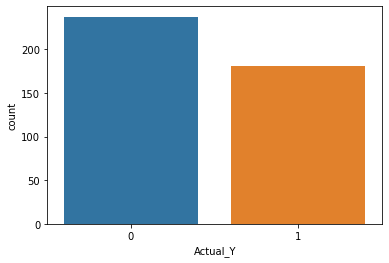

In [13]:
sns.countplot(x='Actual_Y', data=wrong_pred);

## Observations:
<ul> 
    <li> The no. of false positives is higher than no. of false negatives. </li>
</ul>

## 2. Predicted probability of being in +ve class for false positives

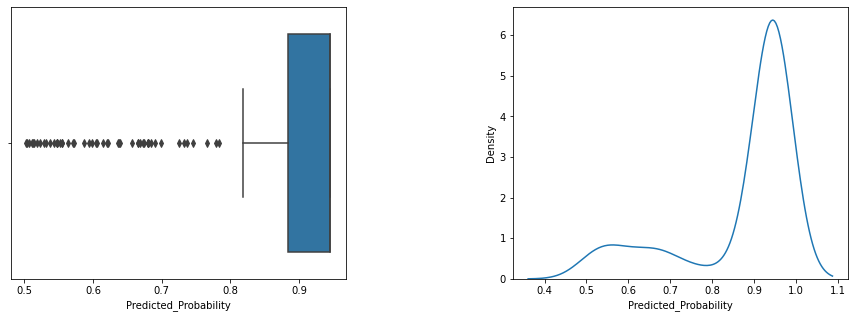

Total no. of false positives:  237
No. of false positives with probability greater than 0.70:  192
No. of false positives with probability less than 0.70:  45
No. of false positives with probability greater than 0.60:  213
No. of false positives with probability less than 0.60:  24


In [14]:
f, axs = plt.subplots(1,2,figsize=(15,5))
df = wrong_pred[wrong_pred['Actual_Y'] == 0]
plt.subplot(1, 2, 1)
sns.boxplot(x='Predicted_Probability', data=df)
plt.subplot(1, 2, 2)
sns.kdeplot(x='Predicted_Probability', data=df)
plt.subplots_adjust(wspace=0.5)
plt.show()

print("Total no. of false positives: ", len(df))
print("No. of false positives with probability greater than 0.70: ", len(df[df['Predicted_Probability']>0.7]))
print("No. of false positives with probability less than 0.70: ", len(df[df['Predicted_Probability']<0.7]))
print("No. of false positives with probability greater than 0.60: ", len(df[df['Predicted_Probability']>0.6]))
print("No. of false positives with probability less than 0.60: ", len(df[df['Predicted_Probability']<0.6]))

## Observations:
<ul>
    <li> Most of the false positives are predicted positive with a probability greater than 0.80 by the model. </li>
    <li> Only 24/237 false positives are predicted as positive with a probability less than 0.60 by the model. </li>
    <li> Majority of the points misclassified by model are done with high confidence(high probability). </li>
</ul>

## 3. Predicted probability of being in +ve class for false negatives

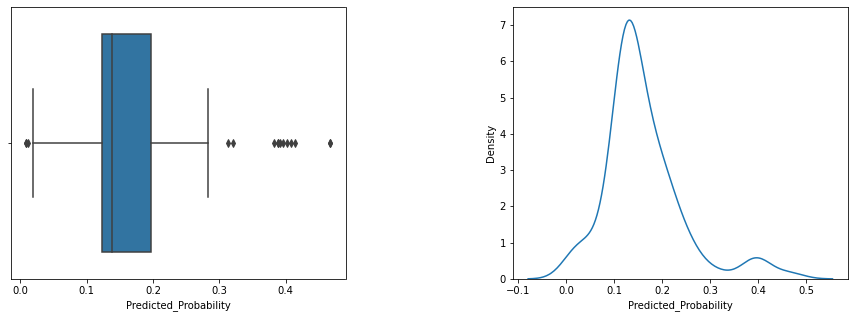

Total no. of false negatives:  181
No. of false negatives with probability being +ve greater than 0.4:  5
No. of false negatives with probability being +ve less than 0.4:  176
No. of false negatives with probability being +ve greater than 0.3:  12
No. of false negatives with probability being +ve less than 0.3:  169


In [15]:
f, axs = plt.subplots(1,2,figsize=(15,5))
df = wrong_pred[wrong_pred['Actual_Y'] == 1]
plt.subplot(1, 2, 1)
sns.boxplot(x='Predicted_Probability', data=df)
plt.subplot(1, 2, 2)
sns.kdeplot(x='Predicted_Probability', data=df)
plt.subplots_adjust(wspace=0.5)
plt.show()
print("Total no. of false negatives: ", len(df))
print("No. of false negatives with probability being +ve greater than 0.4: ", len(df[df['Predicted_Probability']>0.4]))
print("No. of false negatives with probability being +ve less than 0.4: ", len(df[df['Predicted_Probability']<0.4]))
print("No. of false negatives with probability being +ve greater than 0.3: ", len(df[df['Predicted_Probability']>0.3]))
print("No. of false negatives with probability being +ve less than 0.3: ", len(df[df['Predicted_Probability']<0.3]))

## Observations:
<ul>
    <li> Most of the false negatives are predicted -ve with a probability > 0.70. </li>
    <li> Only 5/181 false negatives are predicted +ve with a probability >0.30. </li>
    <li> Majority of the points misclassified by model are done with high confidence(high probability). </li>
</ul>

## 4. Visualizing data for correct and incorrect predictions

In [16]:
set(correct_pred.index).intersection(set(wrong_pred.index))

set()

In [17]:
X.shape

(5410, 33)

In [18]:
# Extracting rows with correct predictions from original data
correct_indices =  correct_pred.index
correct_rows = pd.DataFrame(X.loc[correct_indices])

# Extracting rows with incorrect predictions from original data
wrong_indices =  wrong_pred.index
wrong_rows = pd.DataFrame(X.loc[wrong_indices])

In [20]:
correct_rows.shape, wrong_rows.shape

((4992, 33), (418, 33))

In [21]:
# Concatenating correct rows and incorrect rows
combined = pd.concat([correct_rows, wrong_rows], keys=[1, 0]).reset_index()
combined = combined.drop(['level_1'], axis=1).rename(columns={'level_0': 'is_correct'})
combined.head()

is_correct  Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
0           1                   24            25                      8   
1           1                  117           132                     29   
2           1                  138           149                     23   
3           1                  495          1165                    259   
4           1                   58            72                     11   

   ChronicCond_Alzheimer  ChronicCond_Heartfailure  ChronicCond_KidneyDisease  \
0                     15                        19                         17   
1                     56                        80                         64   
2                     64                        88                         50   
3                    426                       680                        507   
4                     26                        40                         22   

   ChronicCond_Cancer  ChronicCond_ObstrPulmonary  ChronicCond_Depression  \
0                   5                          10                       9   
1                  10                          41                      54   
2                  16                          41                      63   
3                 165                         295                     485   
4                  12                          16                      29   

   ...  OPAnnualDeductibleAmt  InscClaimAmtReimbursed  DeductibleAmtPaid  \
0  ...             463.920000             4185.600000         213.600000   
1  ...             737.121212             4588.409091         502.166667   
2  ...             622.751678              350.134228           2.080537   
3  ...             636.328755              241.124464           3.175966   
4  ...             469.722222              468.194444          45.333333   

         Age  Days_Admitted  Diseases_Count  Total_Physicians  \
0  78.280000       1.000000        5.560000          1.600000   
1  69.553030       2.424242        4.545455          1.530303   
2  71.812081       0.000000        4.342282          1.604027   
3  70.000858       0.000000        4.335622          1.599142   
4  68.791667       0.222222        4.166667          1.527778   

   Total_ClaimCodes  Total_ProcedureCodes  Claim_Period  
0          3.200000              0.120000      1.440000  
1          5.250000              0.363636      3.674242  
2          2.583893              0.000000      1.429530  
3          2.588841              0.000000      1.088412  
4          2.986111              0.013889      0.958333  

[5 rows x 34 columns]

In [22]:
combined.is_correct.value_counts()

1    4992
0     418
Name: is_correct, dtype: int64

In [23]:
labels = combined['is_correct'].values
combined = combined.drop(['is_correct'], axis=1)

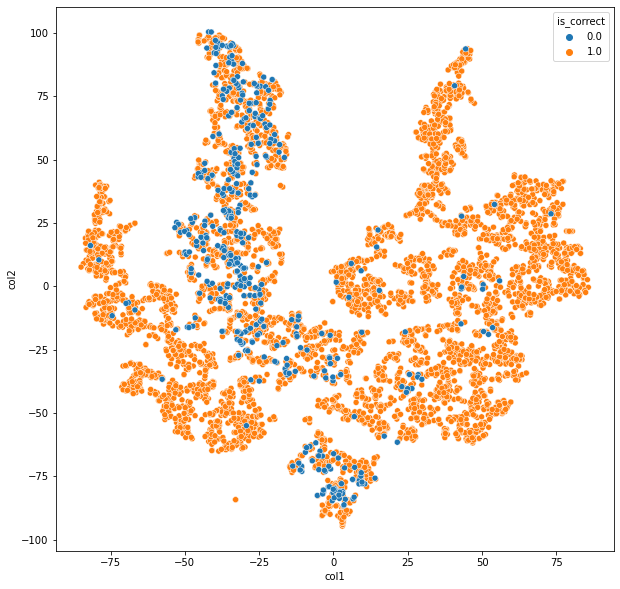

In [24]:
# Reducing dimensions into 2D using TSNE
from sklearn.manifold import TSNE

test_data = combined.values
X_embedded = TSNE(n_components=2, perplexity=30, n_iter=2000).fit_transform(test_data)

df1 = pd.DataFrame(np.hstack([X_embedded, labels.reshape(-1, 1)]), columns=['col1','col2','is_correct'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='col1', y='col2', hue='is_correct', data=df1)
plt.show()

## Observations:
<ul>
    <li> Large no. of data points have been correctly classified. </li>
    <li> Majority of mis-classified points overlap with correctly classified points. </li>
    <li> This suggests that it is very difficult to separate +ve and -ve points distinctly at few regions. </li>
    <li> In some cases, it is very difficult to identify potential fraudulent providers. </li>
</ul>

# 5. Nearest correct data points from wrong predicted data points

In [25]:
# Finding all false postive rows
false_positives = all_predictions[(all_predictions['Actual_Y']==0) & (all_predictions['Predicted_Y']==1)].iloc[:, :33]
print(false_positives.shape)
false_positives.head()

(237, 33)


Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
20              0.545390      0.248938               0.507234   
21              0.629462      0.300327               0.355227   
26              0.279164      0.138819               0.222222   
66              0.335211      0.131478               0.203221   
108             2.289875      1.408861               1.343269   

     ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
20                0.289046                  0.315590   
21                0.444868                  0.422721   
26                0.261549                  0.170647   
66                0.041565                  0.113931   
108               1.306469                  1.475130   

     ChronicCond_KidneyDisease  ChronicCond_Cancer  \
20                    0.349780            0.346051   
21                    0.422482            0.081336   
26                    0.204376            0.273856   
66                    0.213464            0.129466   
108                   1.313084            1.404909   

     ChronicCond_ObstrPulmonary  ChronicCond_Depression  ChronicCond_Diabetes  \
20                     0.394346                0.264870              0.273526   
21                     0.466678                0.307404              0.299717   
26                     0.129130                0.154281              0.189713   
66                     0.177351                0.154281              0.142568   
108                    1.515487                1.336735              1.446905   

     ...  OPAnnualDeductibleAmt  InscClaimAmtReimbursed  DeductibleAmtPaid  \
20   ...               0.106306                0.742047           1.176816   
21   ...              -0.046073                0.058480           0.034237   
26   ...              -0.017778                0.040822           0.226116   
66   ...               0.546892                0.421674           0.283936   
108  ...               0.198734               -0.232547          -0.165001   

          Age  Days_Admitted  Diseases_Count  Total_Physicians  \
20  -0.294154       0.705611        0.282346         -0.130000   
21  -0.127772      -0.001059        0.471154         -0.099957   
26  -0.356442       0.009357        0.343857         -0.205832   
66   0.309385       0.122636       -0.137753          0.440022   
108 -0.082727      -0.132664       -0.110425         -0.092435   

     Total_ClaimCodes  Total_ProcedureCodes  Claim_Period  
20           1.010086              0.914896      0.575857  
21          -0.026165              0.110135     -0.006798  
26          -0.051067             -0.006609     -0.113653  
66           0.463898              0.262508      0.381318  
108         -0.154999             -0.230126      0.044099  

[5 rows x 33 columns]

In [26]:
# Finding all false negative rows
false_negatives = all_predictions[(all_predictions['Actual_Y']==1) & (all_predictions['Predicted_Y']==0)].iloc[:, :33]
print(false_negatives.shape)
false_negatives.head()

(181, 33)


Beneficiaries_Count  Claims_Count  RenalDiseaseIndicator  \
37            -0.211254     -0.209892              -0.214797   
52            -0.127182     -0.165845              -0.138794   
60            -0.260296     -0.257611              -0.195796   
65             0.125032      0.025029              -0.195796   
77            -0.442451     -0.356718              -0.385804   

    ChronicCond_Alzheimer  ChronicCond_Heartfailure  \
37              -0.242580                 -0.201162   
52              -0.224248                 -0.150747   
60              -0.233414                 -0.232671   
65               0.087395                  0.025705   
77              -0.352571                 -0.358708   

    ChronicCond_KidneyDisease  ChronicCond_Cancer  ChronicCond_ObstrPulmonary  \
37                  -0.222750           -0.231509                   -0.244584   
52                  -0.159135           -0.087119                   -0.220473   
60                  -0.204574           -0.255574                   -0.244584   
65                  -0.004643           -0.159314                   -0.039644   
77                  -0.331803           -0.375898                   -0.353082   

    ChronicCond_Depression  ChronicCond_Diabetes  ...  OPAnnualDeductibleAmt  \
37               -0.220021             -0.239828  ...              -0.377095   
52               -0.100925             -0.166492  ...              -0.834705   
60               -0.203007             -0.234590  ...               0.442106   
65               -0.058391              0.074470  ...              -0.675612   
77               -0.339117             -0.349832  ...              -0.438170   

    InscClaimAmtReimbursed  DeductibleAmtPaid       Age  Days_Admitted  \
37               -0.307425          -0.339562 -0.355395      -0.229962   
52                1.155778           0.241313 -1.104659       0.267674   
60                1.277713           1.124365 -0.610385       1.045179   
65                0.062896           0.152274 -0.172457       0.096050   
77               -0.478552          -0.475814  0.727193      -0.430554   

    Diseases_Count  Total_Physicians  Total_ClaimCodes  Total_ProcedureCodes  \
37       -0.436955         -0.527157         -0.072222             -0.350296   
52       -0.044374          0.172525          0.313165              0.471521   
60        1.306610         -0.535580          0.957147              0.545770   
65       -0.116198          0.161836         -0.041101              0.078211   
77        2.965413         -1.762515         -1.200752             -0.438565   

    Claim_Period  
37      0.130555  
52      0.144036  
60      1.053608  
65     -0.165859  
77     -0.978837  

[5 rows x 33 columns]

In [27]:
x = all_predictions.iloc[:, :33]
y = all_predictions['Actual_Y'].values

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(x, y)

KNeighborsClassifier(n_neighbors=20)

In [30]:
# Finding 20 nearest neighbors of all false positive data points
false_pos_neighbors = neigh.kneighbors(false_positives.values, 20)[1]
false_pos_neighbors

array([[  20, 5064, 4379, ..., 5036, 2680, 3114],
       [  21, 1839, 4970, ..., 4183,  918, 3321],
       [  26, 3337, 2340, ...,  700, 2481, 2959],
       ...,
       [5238, 3951, 4965, ...,  860,  773, 1910],
       [5301, 1463, 2569, ..., 4101, 2948, 3293],
       [5365, 4347, 3002, ..., 2961, 3316, 1330]], dtype=int64)

In [31]:
# Finding 20 nearest neighbors of all false negative data points
false_neg_neighbors = neigh.kneighbors(false_negatives.values, 20)[1]
false_neg_neighbors

array([[  37,  335, 2606, ..., 2026, 2113, 1684],
       [  52, 1955, 1083, ...,  215, 4577, 3605],
       [  60, 4582, 2351, ...,  274,  773, 3624],
       ...,
       [5248,  368, 5240, ..., 3369, 2996, 4065],
       [5324, 3299, 4849, ..., 1785,  661, 1014],
       [5329, 4591, 1321, ...,  154, 3984,  816]], dtype=int64)

In [32]:
# Comparing false positive points with correctly classified data points

for data_pt in false_pos_neighbors:
    print("False positive data point:")
    pt_refer_pos = all_predictions.loc[data_pt[0]].values
    print(pt_refer_pos)
    # Nearest correct data points
    df_pos = all_predictions.loc[data_pt[1:]]
    df_pos = df_pos[df_pos['Actual_Y'] == df_pos['Predicted_Y']]
    print()
    print("Difference with Nearest correct data points:")
    print((df_pos-pt_refer_pos).values)
    print('#'*100)

False positive data point:
[ 5.45390328e-01  2.48938146e-01  5.07233754e-01  2.89046479e-01
  3.15589759e-01  3.49780135e-01  3.46050685e-01  3.94345840e-01
  2.64870012e-01  2.73525539e-01  2.90710199e-01  1.77332488e-01
  3.18297686e-01  9.21799168e-02  3.14397880e+00  5.34261207e-01
  1.18857691e+00  3.14397880e+00  2.46002743e-01  2.86210366e-03
  2.07427366e-01  5.49589750e-01  2.30471681e-01  1.06305831e-01
  7.42046614e-01  1.17681590e+00 -2.94154182e-01  7.05610677e-01
  2.82346483e-01 -1.29999935e-01  1.01008638e+00  9.14896275e-01
  5.75856862e-01  0.00000000e+00  1.00000000e+00  9.45678528e-01]

Difference with Nearest correct data points:
[[ 9.10775300e-02  2.20238601e-02 -1.52006459e-01  3.66638676e-02
  -3.15092367e-02  3.63510902e-02 -4.81299365e-02 -2.41105617e-02
  -2.55205840e-02  1.57149060e-02 -1.94917698e-02  2.67895509e-01
   7.10143094e-02  2.20839922e-01 -2.10952425e-01 -4.32105416e-01
  -1.40694015e-01 -2.10952425e-01  1.83625677e-02 -6.02489525e-02
   3.502581

  -0.38211873 -0.16532839 -0.51299616  1.          0.         -0.19436112]]
####################################################################################################
False positive data point:
[ 2.28987533  1.40886144  1.34326928  1.30646881  1.47512967  1.31308403
  1.40490929  1.51548696  1.33673454  1.44690519  1.36763048  1.34209557
  1.46636235  1.49083276  1.66731182 -0.32994963  1.48559761  1.66731182
  1.40651702  1.44883696 -0.14092989 -0.01687291  0.20905205  0.19873354
 -0.23254664 -0.16500087 -0.08272714 -0.13266431 -0.11042533 -0.09243496
 -0.15499906 -0.2301265   0.04409937  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[-4.06345903e-01 -5.50596501e-02 -2.47010496e-01  1.46655470e-01
  -2.20564657e-01  1.81755451e-02  0.00000000e+00 -1.80829213e-01
  -1.78644088e-01 -1.57149060e-01  4.87294246e-03 -1.51419201e-01
   1.30192901e-01 -1.47226615e-01  2.53142910e-01  4.32105416e-01
   4.68980050e-02  2.53142910e-01 -5.87602168e-

[[-0.04904175 -0.01101193  0.11400484  0.01833193  0.04411293  0.04543886
   0.04812994 -0.10849753 -0.06805489 -0.03666811  0.01949177 -0.02329526
  -0.03550715  0.14722661  0.08438097  0.          0.          0.08438097
  -0.00367251  0.          0.52474082  0.53562532 -0.15252721 -0.2224848
   0.31505872  0.38222099 -0.16050171  0.40030401  0.19044557  0.48965253
   0.04841331 -0.29218645  0.37952927  1.          0.          0.        ]
 [-0.05604771 -0.0256945   0.05700242  0.0274979   0.02520739 -0.04543886
  -0.04812994 -0.02411056 -0.04253431  0.0104766   0.00974588 -0.10482868
   0.05917859  0.18403327 -0.08438097  0.43210542 -0.06253067 -0.08438097
  -0.02570759  0.          0.30976821  0.28974369  0.37997657 -0.1923058
   0.41674275  0.25983496 -0.18446112  0.16765634  0.66313108  0.65795122
  -0.04560947  0.0646215   0.1589554   1.          0.          0.        ]
 [-0.09107753 -0.01101193  0.19000807 -0.04582983 -0.01260369  0.04543886
   0.09625987 -0.01205528 -0.00850686 

[[ 0.00700596  0.00734129  0.07600323  0.01833193 -0.01890554  0.00908777
   0.02406497  0.          0.          0.0052383   0.00487294  0.02329526
   0.08285003  0.          0.08438097  0.          0.03126534  0.08438097
   0.00734503  0.          0.46470217  0.85544464  0.15523863  0.01982119
   0.06979974  0.         -0.17264238  0.05695813  0.05189288  0.24494175
   0.07393978 -0.32669758  0.05400215  1.          0.          0.        ]
 [ 0.03502982  0.02202386  0.09500404  0.0274979   0.05671663  0.01817555
   0.19251975  0.04822112 -0.03402745  0.03142981  0.01949177  0.09318105
   0.1301929   0.25764658  0.25314291  0.          0.09379601  0.25314291
   0.02203508  0.          0.20130316  0.29890905 -0.1094463  -0.38281825
   0.34091847  0.         -0.01786296 -0.3469268   0.88925519  0.64575552
   0.15984437  0.         -0.3289222   1.          0.          0.        ]
 [-0.08407157 -0.04771836  0.         -0.0824937  -0.05671663 -0.07270218
   0.09625987 -0.02411056 -0.1616303

[[-0.02802386  0.01835322 -0.01900081  0.06416177  0.01260369  0.14540436
  -0.09625987 -0.12055281 -0.06805489  0.0052383  -0.01949177  0.01164763
  -0.04734287  0.33125988 -0.04219049 -0.43210542  0.06253067 -0.04219049
   0.01101754  0.03012448  0.45442083 -0.19106342  0.15266547 -0.0455169
   0.49094948 -0.24499711 -0.33683805  0.27476096 -0.26447211  0.1204732
  -0.24154153  0.09533185  0.32619001  1.          0.          0.        ]
 [ 0.07005964  0.04037708  0.          0.03666387  0.06301847  0.12722882
   0.09625987 -0.09644225 -0.07656175  0.07333623 -0.00487294 -0.06988578
  -0.03550715  0.11041996 -0.04219049 -0.43210542  0.10942868 -0.04219049
   0.03672514  0.         -0.22501554 -0.42781706  0.40905037  0.3156601
   0.39070985 -0.31563086 -0.53514573 -0.12745428 -0.43101474 -0.38494173
  -0.19373341 -0.3427521  -0.1335118   1.          0.          0.        ]
 [-0.1751491  -0.05873029  0.07600323 -0.07332774 -0.03150924  0.01817555
  -0.16845478 -0.03616584 -0.12760292 -

Difference with Nearest correct data points:
[[-0.03502982 -0.00367064 -0.01900081  0.0549958  -0.03150924  0.07270218
  -0.0721949   0.02411056  0.01701372 -0.0052383  -0.01461883 -0.03494289
  -0.09468575  0.18403327 -0.04219049  0.         -0.01563267 -0.04219049
  -0.01101754  0.          0.16288344 -0.12961387  0.79189031  0.72671543
  -0.16394797 -0.17745975 -0.33151641  0.18910794  0.16035373 -0.02338895
  -0.0060013  -0.01733091  0.17929373  1.          0.          0.        ]
 [-0.11910139 -0.04404772 -0.07600323  0.         -0.07562217 -0.05452664
  -0.0721949  -0.0602764  -0.02552058 -0.05238302 -0.06822119 -0.06988578
  -0.09468575  0.07361331 -0.50628582  0.         -0.18759202 -0.50628582
  -0.04407016  0.          0.00291247 -0.50158741 -0.00787382  0.52620127
   0.13276508  0.         -0.0940586   0.70835988  0.12435305  0.3476978
   0.31990678 -0.42686965  0.67159783  1.          0.          0.        ]
 [ 0.11209542  0.06240094  0.03800161  0.11915757  0.06932032  0.0

[[-0.11209542 -0.17252024 -0.03800161 -0.12832354 -0.15124434 -0.03635109
  -0.16845478  0.01205528 -0.19565781 -0.16762566 -0.18517181 -0.06988578
   0.01183572 -0.11041996 -0.25314291 -0.43210542 -0.25012269 -0.25314291
  -0.17260814 -0.06024895  0.08208663  0.05907999  0.18093022  0.17095702
   0.05110775 -0.04596499  0.00679541 -0.00668986  0.26836875  0.06148639
  -0.02892111 -0.01059781  0.0867211   0.         -1.         -0.36515687]
 [ 0.06305367 -0.17986152 -0.09500404 -0.11915757 -0.19535727 -0.11814104
  -0.16845478  0.08438697 -0.08506861 -0.16238736 -0.13644239  0.05823815
  -0.08285003 -0.18403327 -0.21095243  0.         -0.12506135 -0.21095243
  -0.17628065  0.         -0.0283349   0.11028857 -0.03434259  0.05427668
   0.0470202  -0.01801381 -0.52586092  0.00236835  0.38166437  0.0972259
   0.11168131 -0.04118522 -0.01632871  0.         -1.         -0.38402309]
 [-0.02101789  0.05873029  0.30401292 -0.0549958   0.01260369  0.0999655
  -0.19251975  0.19288449  0.16163037 

[[ 0.09107753  0.02936515 -0.47502019 -0.35747271  0.06301847 -0.22719431
  -0.19251975  0.04822112 -0.12760292  0.         -0.08771296  0.02329526
   0.10652146  0.18403327 -0.2953334   0.          0.046898   -0.2953334
   0.04039765  0.24099581  0.20662201 -0.07402057 -0.14397458  0.16220646
  -0.05776385 -0.06475723  0.27430964 -0.14490507 -0.45323847  0.08168414
  -0.1843427  -0.04090407 -0.07891771  1.          0.          0.        ]
 [ 0.31526837 -0.16884959 -0.49402099 -0.22914917 -0.10082956 -0.21810654
  -0.02406497  0.12055281 -0.21267153 -0.07333623 -0.1949177  -0.08153342
   0.11835718  0.14722661 -0.2953334   0.         -0.20322469 -0.2953334
  -0.15791808  0.03012448  0.08268931  0.10369163 -0.28700108 -0.32729574
   0.09029069  0.03014705  0.05478667  0.07022285  0.34585309  0.11067379
   0.03644867 -0.03372329  0.25257746  1.          0.          0.        ]
 [ 0.28724452 -0.24226246 -0.32301373 -0.11915757 -0.15754618 -0.21810654
  -0.28877962  0.08438697 -0.25520584 

  -0.14417804 -0.10820098 -0.14768913  1.          0.         -0.09456881]]
####################################################################################################
False positive data point:
[-0.23227166 -0.25026935 -0.25279854 -0.17841783 -0.20746357 -0.15913513
 -0.15931365 -0.09992067 -0.23703481 -0.23982806 -0.24044053 -0.24198222
 -0.21430963 -0.12866     1.161026   -0.32994963  0.12555547  1.161026
 -0.24978659 -0.35863161  1.7447546   2.52561932 -0.47055246 -0.68825614
  1.829314    3.04014907 -1.17867185  2.9381125   1.77762215 -0.88982274
  2.79123568  1.53362148  2.21500488  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[-0.09808349 -0.05505965 -0.05700242 -0.07332774 -0.08192402 -0.11814104
  -0.14438981 -0.20493977 -0.03402745 -0.04190642 -0.05360237 -0.01164763
  -0.08285003 -0.18403327 -0.63285728  0.         -0.23449002 -0.63285728
  -0.0550877   0.         -0.80271862 -0.9610306   0.38766627  0.59933409
   0.15476203  0.

   0.18198565  0.05971153 -0.59501635  0.         -1.         -0.76077187]]
####################################################################################################
False positive data point:
[ 2.13574412  1.35380179  1.6472822   1.38896251  1.49403521  1.44940061
  1.0920647   1.56370808  1.4558306   1.32118594  1.38712225  1.55175292
  1.31249802  1.85889929  0.44378775  0.10215579  1.25110759  0.44378775
  1.35142932  1.32833906 -0.24326876 -0.29392987  0.06050321  0.08187619
 -0.32926379 -0.37410358  0.23502941 -0.35995987  0.11344871 -0.07096409
 -0.31311277 -0.335335   -0.30747093  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[-2.80238554e-01  1.83532167e-02 -1.90008074e-01 -2.65813040e-01
  -8.19240155e-02 -3.36247585e-01  2.64714651e-01 -3.61658426e-02
  -9.35754748e-02  9.42894359e-02 -4.87294246e-02 -2.79543139e-01
   1.89371492e-01 -2.57646575e-01 -7.59428731e-01  0.00000000e+00
  -2.65755361e-01 -7.59428731e-01  2.20350813e-

[[-1.02987669e+00  1.90873454e-01  3.80016148e-01  4.49132378e-01
   3.52903452e-01 -1.81755451e-01  3.60974524e-01 -3.85768987e-01
  -4.25343067e-02  2.67153402e-01  2.97249490e-01 -1.51419201e-01
   3.66907265e-01  1.21461957e+00  6.32857276e-01 -4.32105416e-01
   3.28286035e-01  6.32857276e-01  1.90970704e-01  1.11460562e+00
   3.48466439e-01  3.63879087e-01  1.26804160e-01  2.64327144e-01
   4.40975181e-02  4.57355771e-02 -4.06996309e-01  3.74751609e-02
  -6.89521587e-03  1.63991595e+00  8.60331647e-02  3.62851581e-02
   1.85620211e-01  1.00000000e+00  0.00000000e+00  1.79615482e-01]
 [ 6.51554638e-01  3.67064334e-03 -4.75020185e-01  1.74153371e-01
   4.41129314e-02 -3.18072040e-01  1.44389810e-01 -3.73713706e-01
   2.21178395e-01 -7.85745299e-02  1.02331792e-01  4.30962340e-01
   6.98307375e-01  1.65629941e+00  0.00000000e+00 -2.16052708e+00
  -1.09428678e-01  0.00000000e+00  3.67251355e-03 -5.12116096e-01
   1.89627009e-01  1.51845951e-01  7.78186312e-03  3.91345156e-02
   5.8206

[ 0.16006232 -0.03003075  0.03221357  0.10572714  0.01940293  0.12258582
  0.0332061   0.09296382 -0.00734955  0.01161044  0.04219013  0.07250381
  0.02240473  0.23940653  3.10178831  0.10215579  0.87592355  3.10178831
 -0.0367808  -0.29838266  1.28237191  1.38214199  0.05480051  0.06044984
  1.96790506  2.44238992  0.28192048  2.38617535  1.12587884  0.62270176
  2.12261547  2.63877867  1.82472767  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[-0.01401193 -0.00367064  0.13300565 -0.0824937   0.06932032  0.04543886
  -0.02406497  0.10849753  0.00850686  0.02095321 -0.02923765 -0.04659052
   0.16570006  0.          0.04219049 -0.43210542  0.01563267  0.04219049
  -0.00367251  0.06024895  0.10757076  0.15497043 -0.19795909 -0.00958808
   0.17742091  0.06915565 -0.18383777 -0.43903048  0.35465265 -0.37513117
   0.13595241  0.0327377  -0.2597183   1.          0.          0.        ]
 [-0.04203578  0.         -0.01900081  0.00916597 -0.03781108  0.00908

  -1.58352174e-02  1.00000000e+00  0.00000000e+00  0.00000000e+00]]
####################################################################################################
False positive data point:
[-0.1271822  -0.15850326 -0.19579612 -0.14175397 -0.1444451  -0.17731067
  0.00914113 -0.1481418  -0.16897992 -0.13506202 -0.16247345 -0.17209644
 -0.13145961 -0.20227331  0.99226406 -0.32994963  0.18808614  0.99226406
 -0.15797375 -0.32850713  0.96401512  0.80681278 -0.42467231 -0.5394087
  1.28194421  1.33910545 -0.21361294  1.49178279  0.21898255 -0.05772063
  1.13434024  0.98256934  0.85183628  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[-0.06305367 -0.06607158  0.01900081 -0.06416177 -0.05671663 -0.03635109
  -0.24064968  0.01205528 -0.03402745 -0.11000434 -0.06334825 -0.09318105
  -0.1301929  -0.03680665 -0.25314291  0.         -0.17195935 -0.25314291
  -0.06610524  0.03012448 -0.17617095  0.3414073  -0.44264193 -0.20462197
   0.14541357  0.2644647

Difference with Nearest correct data points:
[[ 0.35029819 -0.08809544 -0.09500404  0.1099916  -0.06301847  0.01817555
  -0.26471465  0.01205528  0.18715095 -0.09952774 -0.01949177 -0.03494289
   0.18937149 -0.18403327  0.12657146  0.         -0.14069401  0.12657146
  -0.09181284 -0.15062238  0.06043297  0.14682176 -0.14723763 -0.04459847
  -0.04415239  0.06615132  0.07088496 -0.00902298  0.49882689  0.03964407
   0.16806436  0.0385825   0.03533889  0.         -1.         -0.58775654]
 [ 0.39933994 -0.06607158 -0.13300565  0.1099916  -0.00630185 -0.00908777
  -0.09625987 -0.0602764   0.16163037 -0.04714472  0.0341106   0.
   0.15386434 -0.18403327  0.08438097  0.         -0.18759202  0.08438097
  -0.06610524 -0.15062238 -0.11978993  0.18943543 -0.16323724 -0.02288071
  -0.03587065  0.05669686  0.46515393 -0.00981464  0.48397037  0.30093345
   0.17072585  0.10041391 -0.0626208   0.         -1.         -0.80973374]
 [ 0.23820277 -0.00734129 -0.22800969  0.10082564  0.10082956  0.11814104

[[ 0.06305367  0.04404772  0.          0.03666387  0.03781108  0.02726332
   0.          0.04822112  0.05104117  0.04714472  0.04385648  0.03494289
   0.09468575  0.          0.08438097  0.          0.046898    0.08438097
   0.05141519  0.03012448 -0.86199385  0.80884912 -0.47168388  0.16232712
   0.52573293 -0.49406407 -0.47868254 -0.27670002 -0.44569641  0.02421583
  -0.27796107  0.25377401 -0.0414221   1.          0.          0.        ]
 [-0.09107753 -0.05873029 -0.03800161 -0.07332774 -0.07562217 -0.0999655
  -0.09625987 -0.0602764  -0.09357547 -0.09952774 -0.08771296 -0.01164763
  -0.01183572 -0.03680665 -0.54847631  0.         -0.20322469 -0.54847631
  -0.05141519  0.         -0.43306709  0.32140207 -0.90002288 -0.01089887
   0.22808641  0.55456171  0.54379301  0.22427265  0.10581282 -0.5327483
   0.41611923  0.25377401  0.21263347  0.         -1.         -0.65040308]
 [-0.04203578 -0.03303579 -0.05700242 -0.06416177 -0.06301847 -0.0999655
  -0.02406497 -0.04822112 -0.02552058 -

 -0.4875007  -0.43856511 -0.32994357  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[ 2.80238554e-02  3.59723048e-01  3.80016148e-02  4.39966411e-01
   1.70149878e-01 -4.08949765e-01  1.44389810e-01  1.08497528e-01
   5.10411681e-02  3.09059818e-01  4.38564821e-01  4.42609971e-01
  -1.42028619e-01  1.47226615e-01  4.64095336e-01  4.32105416e-01
   2.97020698e-01  4.64095336e-01  3.59906328e-01  2.40995810e-01
  -2.02447639e-01 -2.78164785e-01 -2.70141184e-01 -4.42694520e-02
   2.46843894e-02  4.00515877e-02 -6.67312271e-03  2.18560274e-02
  -2.16994466e-01  3.74780025e-02  7.99978751e-02  3.14758461e-02
  -6.86839277e-02  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.20357831e-02 -4.11112054e-01  1.71007267e-01 -3.66638676e-01
  -2.33168352e-01 -2.90808722e-01 -6.25689175e-01 -1.68773932e-01
  -4.42356790e-01 -4.24302461e-01 -3.21614202e-01 -6.98857849e-02
  -1.07705036e+00 -2.20839922e-01  0.00000000e+00  4.32105416e-01
  -6.56572069e-01  0.

[[-0.00700596  0.00367064  0.05700242  0.09165967 -0.02520739  0.02726332
   0.0721949   0.         -0.00850686 -0.0052383  -0.00974588  0.05823815
  -0.02367144 -0.11041996  0.04219049  0.          0.01563267  0.04219049
   0.          0.         -0.42378426  0.26022071  0.20279703  0.45761821
  -0.32484836 -0.09087555 -0.18896821 -0.64387806  0.06662846  0.70628936
   0.14164885  1.33132083 -0.61046244  1.          0.          0.        ]
 [-0.04904175 -0.02936515  0.07600323  0.01833193 -0.08822586 -0.05452664
  -0.0721949  -0.09644225 -0.01701372 -0.05762132 -0.0341106  -0.05823815
  -0.02367144 -0.03680665 -0.33752388  0.         -0.12506135 -0.33752388
  -0.02570759  0.         -0.20521338  0.70887033  0.50683311  0.73000426
  -0.56894566  0.09592419 -0.28756395 -0.88669957 -0.42601246  0.09135665
   0.33182975  0.18542295 -0.84068214  1.          0.          0.        ]
 [-0.06305367 -0.04404772  0.07600323 -0.07332774 -0.03781108 -0.05452664
   0.02406497 -0.10849753 -0.0935754

   9.69110987e-02  0.00000000e+00 -1.00000000e+00 -8.09733736e-01]]
####################################################################################################
False positive data point:
[ 0.54539033  0.27463265  0.45023133  0.39903808  0.32819345  0.395219
  0.12946597  0.32201416  0.20532198  0.31543196  0.30532903  0.30545643
  0.63786208  0.16579322  1.66731182  0.10215579  0.59453552  1.66731182
  0.27538285 -0.08751133 -0.0425876   0.04946123 -0.50998353 -0.32686848
  0.20587459  0.43948966  0.03015257  0.32398109  0.37412184  0.28068428
  0.23903     0.26858045 -0.09144175  0.          1.          0.94567853]

Difference with Nearest correct data points:
[[ 0.32227434  0.08075415 -0.05700242 -0.0824937   0.06301847  0.00908777
   0.31284459  0.03616584  0.10208234  0.03142981  0.07309414  0.03494289
  -0.40241442  0.18403327  0.          0.          0.21885736  0.
   0.0807953   0.36149371  0.20632     0.21854097  0.2037706   0.01807988
   0.11532866 -0.10550203  0.1937

In [34]:
# Maximum difference of each false positive with correct data points along axis 1

for data_pt in false_pos_neighbors:
    print("False positive data point:")
    pt_refer_pos = all_predictions.loc[data_pt[0]].values
    print(pt_refer_pos)
    # Nearest correct data points
    df_pos = all_predictions.loc[data_pt[1:]]
    df_pos = df_pos[df_pos['Actual_Y'] == df_pos['Predicted_Y']]
    print()
    print("Difference with Nearest correct data points:")
    print((df_pos-pt_refer_pos).values.max(axis=1))
    print('#'*100)

False positive data point:
[ 5.45390328e-01  2.48938146e-01  5.07233754e-01  2.89046479e-01
  3.15589759e-01  3.49780135e-01  3.46050685e-01  3.94345840e-01
  2.64870012e-01  2.73525539e-01  2.90710199e-01  1.77332488e-01
  3.18297686e-01  9.21799168e-02  3.14397880e+00  5.34261207e-01
  1.18857691e+00  3.14397880e+00  2.46002743e-01  2.86210366e-03
  2.07427366e-01  5.49589750e-01  2.30471681e-01  1.06305831e-01
  7.42046614e-01  1.17681590e+00 -2.94154182e-01  7.05610677e-01
  2.82346483e-01 -1.29999935e-01  1.01008638e+00  9.14896275e-01
  5.75856862e-01  0.00000000e+00  1.00000000e+00  9.45678528e-01]

Difference with Nearest correct data points:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
####################################################################################################
False positive data point:
[ 0.62946189  0.30032715  0.35522729  0.44486792  0.42272116  0.42248232
  0.08133603  0.46667753  0.30740432  0.29971705  0.35405845  0.60829483
  0.25911909  0.3130

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
####################################################################################################
False positive data point:
[ 0.05497286 -0.07040782  0.12721761 -0.05926026 -0.0121063   0.05897141
 -0.08711874 -0.05169955  0.00966417 -0.05124918 -0.05039577  0.1423896
 -0.01310242  0.05537326  0.99226406 -0.32994963  0.21935148  0.99226406
 -0.08085096 -0.17788475  0.91038769  0.81109279  0.37183428  0.38114797
  0.69547218  0.68232715 -0.2984977   0.37499656  0.89618458 -0.34185306
  0.76353751  0.3348414   0.2419977   0.          1.          0.94567853]

Difference with Nearest correct data points:
[1.         0.47708803 1.         1.         1.         0.89975269
 1.         0.87746779 1.        ]
####################################################################################################
False positive data point:
[ 2.30121955e-01  3.00504240e-03  8.92159907e-02  2.32334388e-02
  4.46103231e-02  1.13498048e-01 -1.49238389e-02  4.474269

 1.         0.43227936 1.         1.        ]
####################################################################################################
False positive data point:
[-0.09915835 -0.14015005 -0.21479693 -0.0775922  -0.12553956 -0.09552072
  0.08133603 -0.12403124 -0.10092503 -0.0931556  -0.12348991 -0.16044881
 -0.13145961  0.01856661  0.52816872  0.53426121  0.06302479  0.52816872
 -0.14328369 -0.14776028  0.12419846  0.2991294   0.24399038  0.22351224
  0.28805534  0.52841111 -0.24354026  0.64201127  0.7630594  -0.24349953
  0.44999343  0.62338152  0.89046859  0.          1.          0.94567853]

Difference with Nearest correct data points:
[0.17548335 0.33251219 0.43857124 0.39655067 0.63417538 0.70723699
 0.3787345  0.52422246 0.68982204 1.         1.        ]
####################################################################################################
False positive data point:
[ 1.81080208e-01  6.67568574e-03 -4.37896611e-02 -4.26446187e-03
  4.46103231e-02 -4.6429

Difference with Nearest correct data points:
[1.         1.         1.         1.         1.         1.
 1.         1.06264658 1.         1.         1.         1.        ]
####################################################################################################
False positive data point:
[-0.38640286 -0.3310235  -0.32880177 -0.30674137 -0.32089682 -0.32271503
 -0.32776843 -0.29280517 -0.3050897  -0.32364089 -0.32815349 -0.32351564
 -0.34450253 -0.16546666  0.23283533 -0.32994963 -0.21836324  0.23283533
 -0.3342544  -0.35863161  3.74198979  1.8303527  -1.05429231 -1.10626176
  4.49002805  2.76713408 -1.14462466  3.31553837  1.82227283  2.44483037
  3.05971509  3.3094818   2.57284331  0.          1.          0.63915224]

Difference with Nearest correct data points:
[1.17214531 1.21464483 2.43771627 0.48505267 0.34509715 1.28908489
 0.50138616 1.51813134 0.84233043 1.12441407 1.         1.73034324]
################################################################################

[1. 1. 1. 1. 1. 1. 1.]
####################################################################################################
False positive data point:
[-0.15520606 -0.19153905 -0.29080016 -0.14175397 -0.19485988 -0.14095958
 -0.25557352 -0.19636292 -0.25404853 -0.18744504 -0.1917111  -0.24198222
 -0.1906382  -0.09185335  0.78131163 -0.32994963  0.06302479  0.78131163
 -0.19102637 -0.32850713  1.13100668  0.93115339 -0.14477634  0.24083646
  1.26035907  1.30490891  0.51498128  1.1073154  -0.01117762  0.61918309
  1.18315354  1.23335778  0.66981726  0.          1.          0.94567853]

Difference with Nearest correct data points:
[0.28488356 1.         1.         0.72552057 0.40499225 1.
 0.78350151 1.         1.        ]
####################################################################################################
False positive data point:
[-0.16221202 -0.1952097  -0.10079208 -0.11425606 -0.1444451  -0.08643295
 -0.03898881 -0.13608652 -0.20300736 -0.17173013 -0.16247345 -0.19539

[1.         1.         1.         1.         1.         0.24099581
 1.         0.49379495 1.         1.         0.15062238 0.88806392]
####################################################################################################
False positive data point:
[ 0.54539033  0.27463265  0.45023133  0.39903808  0.32819345  0.395219
  0.12946597  0.32201416  0.20532198  0.31543196  0.30532903  0.30545643
  0.63786208  0.16579322  1.66731182  0.10215579  0.59453552  1.66731182
  0.27538285 -0.08751133 -0.0425876   0.04946123 -0.50998353 -0.32686848
  0.20587459  0.43948966  0.03015257  0.32398109  0.37412184  0.28068428
  0.23903     0.26858045 -0.09144175  0.          1.          0.94567853]

Difference with Nearest correct data points:
[1. 1. 1. 1. 1. 1. 1. 1.]
####################################################################################################
False positive data point:
[ 1.89053539  1.56302846  1.26726605  1.23314107  1.60116662  1.54027834
  1.14019464  1.22616022  1

In [33]:
# Comparing false negative points with correctly classified data points

for data_pt in false_neg_neighbors:
    print("False negative data point:")
    pt_refer_neg = all_predictions.loc[data_pt[0]].values
    print(pt_refer_neg)
    # Nearest correct data points
    df_neg = all_predictions.loc[data_pt[1:]]
    df_neg = df_neg[df_neg['Actual_Y'] == df_neg['Predicted_Y']]
    print()
    print("Difference with nearest correct data points:")
    print((df_neg-pt_refer_neg).values)
    print('#'*100)

False negative data point:
[-0.21125377 -0.20989227 -0.21479693 -0.2425796  -0.20116172 -0.22274954
 -0.23150855 -0.24458404 -0.22002108 -0.23982806 -0.2258217  -0.20703933
 -0.22614535 -0.20227331 -0.23126001 -0.32994963 -0.20273057 -0.23126001
 -0.20938894 -0.14776028 -0.52012511 -0.39975488 -0.05580019 -0.37709451
 -0.30742472 -0.33956184 -0.3553951  -0.22996249 -0.43695468 -0.52715682
 -0.07222199 -0.35029589  0.13055537  1.          0.          0.12245879]

Difference with nearest correct data points:
[[ 1.33113313e-01  4.40477201e-02  9.50040371e-02  4.58298345e-02
   3.78110841e-02  2.72633177e-02  2.40649683e-02  7.23316851e-02
   5.95480294e-02  7.33362279e-02  5.84753095e-02  2.32952616e-02
   5.91785911e-02 -7.36133073e-02  1.26571455e-01  0.00000000e+00
  -4.68980050e-02  1.26571455e-01  4.40701626e-02  3.01244762e-02
   3.05267880e-01  1.86320042e-01  2.13615840e-01  3.61683463e-01
   9.86497537e-02  1.46221514e-01  1.98372000e-01  2.68992678e-03
   1.78522774e-01  1.11821

  -6.10387955e-01 -1.00000000e+00  0.00000000e+00  8.73364442e-03]]
####################################################################################################
False negative data point:
[ 0.1250325   0.0250289  -0.19579612  0.08739521  0.02570478 -0.004643
 -0.15931365 -0.03964427 -0.05839072  0.07447006  0.01782542 -0.05562013
  0.12892619  0.12898657  0.52816872 -0.32994963  0.20371881  0.52816872
  0.02565193 -0.14776028 -0.17680464 -0.12092823 -0.63130686 -0.67561156
  0.0628959   0.15227416 -0.17245669  0.09604965 -0.11619825  0.16183624
 -0.04110064  0.07821106 -0.16585881  1.          0.          0.18593437]

Difference with nearest correct data points:
[[ 1.61137169e-01  2.56945034e-02  3.61015341e-01  2.74979007e-02
   4.41129314e-02  9.99654982e-02  2.64714651e-01  7.23316851e-02
   7.65617521e-02 -3.66681140e-02  3.89835397e-02  5.82381541e-02
  -1.18357182e-01 -3.68066536e-02 -2.10952425e-01  0.00000000e+00
  -6.25306733e-02 -2.10952425e-01  2.57075948e-02  2.4099

  2.68785202  2.4037038   2.18028921  1.          0.          0.15267067]

Difference with nearest correct data points:
[[ 0.         -0.01835322 -0.07600323 -0.0549958  -0.05671663 -0.02726332
  -0.02406497  0.         -0.04253431 -0.02619151 -0.0341106  -0.04659052
   0.01183572  0.         -0.21095243  0.         -0.07816334 -0.21095243
  -0.01836257  0.          0.21151569 -0.85161518 -1.22610003 -1.18860662
   0.13872341  0.          1.16716549  0.7347599  -0.8088802   0.07103311
   0.16403541  0.40603841  0.69662775 -1.          0.          0.02032933]
 [-0.04904175 -0.04771836 -0.11400484 -0.06416177 -0.06932032 -0.07270218
   0.         -0.03616584 -0.06805489 -0.04714472 -0.06334825 -0.08153342
  -0.01183572 -0.07361331 -0.54847631  0.         -0.20322469 -0.54847631
  -0.04774268  0.          0.52579521 -0.75366407 -1.39095382 -1.52895586
   1.15010594  0.          0.96101678 -0.62247101  0.71751168  0.27398484
   0.30188029  0.63806037 -0.59016637 -1.          0.          0.

Difference with nearest correct data points:
[[ 0.02802386  0.01101193  0.05700242  0.04582983  0.          0.
   0.          0.08438697 -0.00850686  0.01571491 -0.00974588  0.02329526
   0.03550715 -0.07361331  0.12657146  0.          0.046898    0.12657146
   0.01101754  0.         -0.05749529  0.33788423 -0.18299412  0.18290541
  -0.40154357  0.         -0.94271059  0.34503484 -0.22790453 -0.43029671
  -0.05288472 -0.46850586  0.32712842 -1.          0.          0.12246214]
 [-0.02101789 -0.01468257  0.03800161 -0.01833193 -0.04411293 -0.00908777
   0.         -0.01205528 -0.02552058  0.         -0.01949177 -0.02329526
  -0.01183572 -0.18403327 -0.16876194  0.         -0.06253067 -0.16876194
  -0.01836257  0.         -0.04170953 -0.29301613  0.07535245 -0.24517801
  -0.45137238 -0.39435499 -0.57133975  0.24535811 -0.21222856  1.01996256
   0.10391383  0.65937862  0.23262465 -1.          0.         -0.05681331]
 [-0.00700596 -0.00734129  0.01900081  0.         -0.03150924 -0.03635109

  -1.28437550e-01 -1.00000000e+00  0.00000000e+00 -1.02000000e-01]]
####################################################################################################
False negative data point:
[-0.11317027 -0.18786841 -0.06279047 -0.19674977 -0.19485988 -0.12278404
 -0.03898881 -0.23252876 -0.17748678 -0.17696843 -0.15272756 -0.24198222
 -0.20247392 -0.27588662  0.35940678 -0.32994963 -0.04640389  0.35940678
 -0.18735386 -0.05738685  0.38066247  0.0327481   0.95021761  1.00197107
  0.61743698  0.58429227 -0.5977709   0.48625269  0.21608852  0.80560482
  0.71052025  0.73269955  0.92785469  1.          0.          0.27657338]

Difference with nearest correct data points:
[[-0.09808349 -0.00734129 -0.11400484  0.00916597 -0.03150924 -0.07270218
  -0.24064968  0.03616584 -0.02552058  0.01571491 -0.02923765  0.01164763
  -0.03550715  0.25764658  0.04219049  0.          0.01563267  0.04219049
  -0.00734503 -0.09037343 -0.48037351 -0.0747685  -0.57476709 -0.60756453
  -0.10318814  0.113388

[[ 6.02512891e-01 -3.78076264e-01 -2.28009689e-01  2.84144974e-01
  -2.83583131e-01  1.27228816e-01  1.27544332e+00 -2.04939774e-01
  -8.67699857e-01 -3.61442838e-01 -4.48310706e-01  6.98857849e-02
  -3.55071547e-01  5.15293151e-01  4.21904851e-02  8.64210832e-01
  -1.56326683e-02  4.21904851e-02 -3.78268895e-01  1.50622381e-01
   8.75097088e-02  2.64260663e-01  5.41599031e-02  2.45370052e-01
  -6.88402544e-03  4.77893854e-03 -1.13073701e-01  3.39485555e-03
   3.75745834e-01 -3.06204144e-01  8.65111968e-02  1.34449806e-02
   5.71701122e-02 -1.00000000e+00  0.00000000e+00 -2.10000000e-02]
 [ 9.10775300e-01 -1.17460587e-01 -4.94020993e-01 -2.19983206e-01
  -2.58375741e-01 -5.08915263e-01  1.13105351e+00 -5.30432357e-01
  -4.93397958e-01 -5.76213219e-02 -2.68011835e-01  1.51419201e-01
  -1.53864337e-01  1.25142622e+00  0.00000000e+00  4.32105416e-01
  -3.43918703e-01  0.00000000e+00 -1.17520434e-01 -3.91618191e-01
  -1.82946775e-01 -1.62891217e-01 -3.22787888e-01 -1.84503008e-01
  -2.1860

  -0.13622908  0.12743706  0.35842559 -1.          0.         -0.12061991]]
####################################################################################################
False negative data point:
[-0.21125377 -0.1952097  -0.10079208 -0.19674977 -0.1318414  -0.17731067
 -0.20744358 -0.25663933 -0.16047306 -0.16649183 -0.1917111  -0.1953917
 -0.26165251 -0.0550467   0.35940678  0.53426121 -0.06203655  0.35940678
 -0.1983714  -0.20800923 -0.00678601  0.63644694 -0.43591999 -0.46994657
  0.46970427  0.55571261  0.76397658  0.45115772  0.33937402  0.34006477
  0.63258487  0.53592709  0.30425446  1.          0.          0.16459327]

Difference with nearest correct data points:
[[-0.01401193 -0.05505965 -0.19000807 -0.01833193 -0.12603695 -0.05452664
  -0.0721949   0.02411056 -0.08506861 -0.08905113 -0.06334825 -0.09318105
   0.         -0.18403327 -0.16876194 -0.86421083 -0.10942868 -0.16876194
  -0.05141519  0.          0.00331184 -0.28666291  0.05782327 -0.09624222
  -0.08152837  0

[[ 0.10508946  0.05505965  0.15200646  0.11915757  0.06301847  0.04543886
   0.02406497  0.07233169  0.08506861  0.06285962  0.07796708  0.02329526
  -0.11835718  0.          0.08438097  0.          0.10942868  0.08438097
   0.05141519  0.06024895 -0.21591292 -0.36558427 -0.11269592 -0.39975396
  -0.18463178 -0.26659579 -0.198372    0.28767984 -0.12268153 -0.40492303
  -0.10115284 -0.12096152  0.14204914  0.          1.          0.73461017]
 [ 0.         -0.00367064  0.03800161  0.00916597  0.00630185 -0.02726332
   0.16845478  0.07233169 -0.02552058 -0.02619151  0.02436471 -0.05823815
  -0.08285003 -0.11041996 -0.21095243  0.          0.         -0.21095243
  -0.00367251  0.06024895 -0.18765974 -0.13615953  0.02665244 -0.09347692
  -0.011637   -0.30371549 -0.64798038  0.32580768 -0.02484494 -0.18465629
   0.07140769 -0.13761609  0.33063581 -1.          0.         -0.04206836]
 [-0.00700596  0.00367064 -0.11400484  0.07332774 -0.01260369 -0.03635109
   0.0721949  -0.03616584 -0.0085068

[[-2.90747500e+00 -6.05656151e-01 -4.56019378e-01 -4.30800445e-01
  -4.85242246e-01 -4.72564173e-01 -2.16584714e-01 -5.30432357e-01
  -1.19096059e-01 -4.71447179e-01 -8.38146103e-01 -2.44600247e-01
  -5.79950193e-01  7.72939726e-01  0.00000000e+00  0.00000000e+00
  -2.18857356e-01  0.00000000e+00 -6.05964735e-01  3.01244762e-02
  -9.65313145e-02 -7.32741078e-02  3.08579035e-01  1.93015167e-01
   4.72268108e-03 -6.24944917e-04  1.35597662e-01  0.00000000e+00
   1.27184078e-01 -1.47578136e-01  2.35906702e-02  0.00000000e+00
   4.40898231e-02  0.00000000e+00  1.00000000e+00  8.23227565e-01]
 [-3.36286265e+00 -5.54267145e-01  4.94020993e-01  2.65813040e-01
  -1.82753573e-01  9.99654982e-02 -7.70078984e-01  1.44663370e-01
  -6.12494017e-01 -5.34306803e-01 -5.84753095e-01 -5.82381541e-02
  -7.45650248e-01  9.20166341e-01  0.00000000e+00 -4.32105416e-01
  -6.72204738e-01  0.00000000e+00 -5.54549546e-01  8.43485335e-01
   2.06522067e-02 -3.98789331e-02  3.69110724e-01  4.30304708e-01
   1.3623

Difference with nearest correct data points:
[[ 0.          0.01101193  0.07600323  0.03666387  0.00630185  0.05452664
   0.          0.02411056  0.04253431  0.03142981  0.         -0.02329526
   0.01183572 -0.07361331  0.04219049 -0.43210542  0.03126534  0.04219049
   0.01101754  0.          0.59940193 -0.24411415  0.5229889   0.36297978
   0.71491434 -0.28547872  0.20621461 -0.76782038  0.30179656 -1.63993825
   0.02768884  0.0794423  -0.72797248  0.          1.          0.56367508]
 [-0.06305367 -0.03670643 -0.07600323 -0.0274979  -0.01890554 -0.04543886
  -0.04812994 -0.04822112 -0.01701372 -0.03142981 -0.04872942  0.01164763
  -0.10652146 -0.22083992 -0.42190485 -0.43210542 -0.15632668 -0.42190485
  -0.03305262  0.          0.39094935  0.25712166  0.93273789  0.38218707
   0.68883351  0.17745975  1.45365156 -0.53825435  0.0564335  -0.21309932
  -0.69473819  0.20301921 -0.51032033 -1.          0.         -0.19300345]
 [-0.05604771 -0.0256945  -0.07600323  0.         -0.03781108 -0.

[[ 7.00596385e-03  2.20238601e-02  9.50040371e-02 -1.09991603e-01
   7.56221682e-02 -1.09053271e-01  1.20324841e-01 -3.61658426e-02
  -6.80548908e-02 -5.76213219e-02  1.46188274e-02 -1.16476308e-02
   1.65700055e-01 -2.57646575e-01  1.26571455e-01  0.00000000e+00
   1.09428678e-01  1.26571455e-01  2.57075948e-02  6.02489525e-02
  -1.21108882e-01 -4.08375313e-01 -5.03304957e-02 -1.02537633e-01
   1.26012737e-02  8.22537388e-02  1.88128452e-01  7.30923646e-02
  -3.66139685e-01  2.64447999e-01  1.32510142e-01  4.60628122e-02
   1.42217747e-01 -1.00000000e+00  0.00000000e+00  7.10000000e-02]
 [-9.80834939e-02  1.83532167e-02 -1.33005652e-01 -3.66638676e-02
   3.15092367e-02 -4.54388628e-02  4.81299365e-02 -1.44663370e-01
  -4.25343067e-02 -2.09532080e-02  2.92376548e-02 -1.16476308e-02
  -2.36714365e-02 -7.36133073e-02 -1.26571455e-01 -4.32105416e-01
  -7.81633416e-02 -1.26571455e-01  2.20350813e-02 -2.10871334e-01
   2.48722155e-01  8.98002107e-02 -1.80942964e-01 -3.30439548e-01
  -1.1576

Difference with nearest correct data points:
[[ 0.         -0.0844248  -0.11400484 -0.03666387 -0.12603695 -0.09087773
  -0.19251975 -0.16877393 -0.17864409 -0.11000434 -0.13644239 -0.12812394
   0.07101431 -0.11041996  0.         -0.43210542 -0.06253067  0.
  -0.08814033 -0.15062238 -0.4983179  -0.16980076 -0.20358426 -0.28509875
   0.15633082  0.02142427 -0.79789765  0.1179957  -0.3223319  -0.04031609
  -0.25791895  0.10974011 -0.27037564 -1.          0.          0.        ]
 [ 0.01401193 -0.07708351 -0.11400484 -0.01833193 -0.16384803 -0.07270218
  -0.19251975 -0.20493977 -0.13610978 -0.11000434 -0.10720473 -0.09318105
   0.         -0.25764658  0.04219049 -0.43210542 -0.09379601  0.04219049
  -0.0807953  -0.06024895 -0.2315313   0.0147825  -0.02010275 -0.13238868
   0.11653871  0.09257287 -0.7734852   0.31480321 -0.64536775  0.06010494
   0.29615442  0.52056207  0.11527382 -1.          0.          0.        ]
 [ 0.02802386 -0.0256945   0.03800161  0.06416177 -0.05671663 -0.01817555

Difference with nearest correct data points:
[[-0.27323259 -0.09543673 -0.05700242 -0.12832354 -0.05041478 -0.03635109
  -0.19251975 -0.04822112 -0.23819212 -0.14143415 -0.10720473 -0.18636209
  -0.10652146 -0.11041996 -0.12657146  0.43210542 -0.20322469 -0.12657146
  -0.09181284 -0.18074686 -0.00418521 -0.06851346 -0.12635627  0.19256642
   0.169996    0.14503565 -0.71688994 -0.09801331 -0.153891    0.12793666
   0.00216364  0.29418817 -0.15075682 -1.          0.         -0.07596951]
 [ 0.1541312   0.09176608  0.17100727 -0.07332774  0.08822586  0.17266768
   0.16845478  0.02411056 -0.02552058  0.02619151  0.02436471  0.1514192
   0.10652146  0.36806654 -0.04219049  0.         -0.06253067 -0.04219049
   0.09181284  0.06024895 -0.28517379 -0.42078857 -0.13342142 -0.14423238
   0.24951396 -0.14793547 -0.09079249 -0.32128142 -0.47007247  0.20139057
  -0.25596734 -0.11303634 -0.55135603  0.          1.          0.31260628]
 [-0.05604771 -0.01835322  0.19000807 -0.1649874   0.03150924  0.0

Difference with nearest correct data points:
[[ 0.24520873 -0.02202386  0.01900081  0.03666387 -0.1071314   0.10905327
   0.         -0.07233169 -0.14461664 -0.03666811 -0.01949177  0.05823815
   0.03550715  0.07361331 -0.16876194  0.         -0.09379601 -0.16876194
  -0.02203508  0.24099581 -0.15111299 -0.37900126 -0.05806204  0.2566498
  -0.02781034 -0.12526136  0.14459537 -0.05221162  0.00307372  0.35748688
   0.10973534 -0.0751923   0.23268574 -1.          0.          0.        ]
 [ 0.25922066 -0.13214316 -0.13300565 -0.04582983 -0.19535727 -0.07270218
  -0.26471465 -0.16877393 -0.17864409 -0.17286397 -0.15106122 -0.02329526
  -0.10652146  0.14722661  0.04219049  0.         -0.14069401  0.04219049
  -0.13221049  0.15062238 -0.10090942  0.18849882 -0.27969753 -0.28767636
   0.05114429  0.11778955  0.10315857  0.09730348 -0.14630908 -0.03946284
   0.09649142  0.20677882  0.39826587 -1.          0.          0.        ]
 [ 0.25922066  0.03670643  0.09500404  0.14665547 -0.08822586  0.1

[[-0.16113717 -0.01468257 -0.01900081 -0.23831514 -0.03781108 -0.02726332
  -0.31284459 -0.10849753 -0.07656175 -0.04714472 -0.00974588  0.17471446
  -0.31956439 -0.03680665 -0.08438097  0.         -0.12506135 -0.08438097
  -0.01101754 -0.24099581 -0.17667792  0.0824071   0.16966051 -0.45201048
  -0.07928763 -0.01695922 -0.03015765 -0.03605692 -0.31185316  0.0066047
  -0.14820124 -0.01433241 -0.23999699 -1.          0.         -0.13371066]
 [ 0.14712524 -0.17619088  0.17100727  0.04582983 -0.20796096 -0.15449213
   0.         -0.0602764  -0.07656175 -0.14143415 -0.13156945  0.
  -0.34323583 -0.44167984  0.08438097  0.          0.03126534  0.08438097
  -0.17628065 -0.30124476  0.15979617  0.29653616 -0.04832371 -0.36820746
  -0.00571424  0.04493001  0.54240877 -0.00503889  0.29670701  0.17345465
   0.14390846  0.0540563  -0.07694105 -1.          0.         -0.23176206]
 [ 0.21718488 -0.12480187 -0.11400484  0.10082564 -0.18905542 -0.09087773
  -0.36097452  0.0602764  -0.12760292 -0.0942

[[ 1.89161024e-01  4.40477201e-02 -1.71007267e-01  1.28323537e-01
   6.30184735e-03 -9.08777256e-02  7.21949048e-02 -3.61658426e-02
   6.80548908e-02  4.19064160e-02  4.38564821e-02  1.39771570e-01
   0.00000000e+00  7.36133073e-02  0.00000000e+00  0.00000000e+00
   1.40694015e-01  0.00000000e+00  4.40701626e-02  6.02489525e-02
  -1.13659295e-01 -8.67721503e-03 -7.64389791e-02  2.67016480e-01
   5.88160686e-03  3.13510966e-03 -2.19048002e-01  0.00000000e+00
  -2.34771681e-01  2.86355277e-01 -1.01775575e-01  0.00000000e+00
   2.34845988e-02 -1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.12095422e-01  7.34128668e-02 -5.70024222e-02  7.33277352e-02
   1.89055420e-02  9.08777256e-03  1.20324841e-01  3.61658426e-02
   9.35754748e-02  5.76213219e-02  6.82211944e-02  1.04828677e-01
   4.73428729e-02 -3.68066536e-02  0.00000000e+00  0.00000000e+00
   1.09428678e-01  0.00000000e+00  7.34502709e-02  9.03734287e-02
  -2.97305670e-01 -1.34335186e-01  5.22769762e-02  3.09636582e-01
  -5.1435

[[ 2.45208735e-01  5.87302935e-02 -5.51023415e-01 -1.28323537e-01
  -8.19240155e-02  8.17899531e-02 -9.62598730e-02  6.02764043e-02
   7.65617521e-02  2.04293778e-01  1.90044756e-01  3.49428924e-02
   2.95892956e-01  1.10419961e-01  0.00000000e+00 -4.32105416e-01
   1.56326683e-01  0.00000000e+00  5.87602168e-02 -3.01244762e-01
   2.31918024e-01  1.19975444e-01 -5.95208415e-03  6.10704716e-02
  -2.59510707e-03 -3.25442083e-03 -4.98307686e-02  0.00000000e+00
   9.73803776e-02  7.01459527e-02  5.90339267e-03  0.00000000e+00
  -3.85705632e-01 -1.00000000e+00  0.00000000e+00 -1.06170934e-01]
 [ 6.09518855e-01  1.65178950e-01 -3.04012919e-01  3.66638676e-02
   1.26036947e-01  3.08984267e-01 -4.81299365e-02  2.65216179e-01
   2.89233286e-01  1.67625664e-01  2.14409468e-01 -4.65905232e-02
   5.68114475e-01  0.00000000e+00  0.00000000e+00  4.32105416e-01
  -4.68980050e-02  0.00000000e+00  1.65263110e-01 -6.02489525e-02
   3.92354035e-02  1.11707150e-01 -1.97728607e-01 -2.43573938e-02
  -2.1610

In [36]:
# Maximum difference of each false negative with correct data points along axis 1

for data_pt in false_neg_neighbors:
    print("False negative data point:")
    pt_refer_neg = all_predictions.loc[data_pt[0]].values
    print(pt_refer_neg)
    # Nearest correct data points
    df_neg = all_predictions.loc[data_pt[1:]]
    df_neg = df_neg[df_neg['Actual_Y'] == df_neg['Predicted_Y']]
    print()
    print("Difference with nearest correct data points:")
    print((df_neg-pt_refer_neg).values.max(axis=1))
    print('#'*100)

False negative data point:
[-0.21125377 -0.20989227 -0.21479693 -0.2425796  -0.20116172 -0.22274954
 -0.23150855 -0.24458404 -0.22002108 -0.23982806 -0.2258217  -0.20703933
 -0.22614535 -0.20227331 -0.23126001 -0.32994963 -0.20273057 -0.23126001
 -0.20938894 -0.14776028 -0.52012511 -0.39975488 -0.05580019 -0.37709451
 -0.30742472 -0.33956184 -0.3553951  -0.22996249 -0.43695468 -0.52715682
 -0.07222199 -0.35029589  0.13055537  1.          0.          0.12245879]

Difference with nearest correct data points:
[0.36168346 0.32696054 0.36510993 0.48973136 0.24613012 0.5250119
 0.37531779 0.35407857 0.34123009 0.48132121 0.33270824 0.41945398
 0.31744371 0.43289053 0.34245238 0.50818152 0.48026751 0.30065788
 0.34257652]
####################################################################################################
False negative data point:
[-0.1271822  -0.16584455 -0.1387937  -0.22424767 -0.15074694 -0.15913513
 -0.08711874 -0.22047348 -0.10092503 -0.16649183 -0.17221933 -0.13715354
 

[0.60251289 0.52544729 0.43210542 0.87574548 0.91778126 0.54646518
 0.95281108 0.47640554 1.22604367 1.         0.43210542 1.25406753
 0.84772163 0.68658446 0.93179319 0.42862706 0.86421083 1.        ]
####################################################################################################
False negative data point:
[ 1.02179587  2.21640298  2.08430077  2.01224826  2.17463473  2.05828138
  0.5626354   2.63662808  2.54470885  2.21693558  2.24963307  1.71481976
  1.96346252  0.46024645 -0.31564098 -0.32994963  1.72008763 -0.31564098
  2.21814252  2.38269573 -0.32882219 -0.38544496  0.55257934  0.2868521
 -0.40300914 -0.5009611   0.07304823 -0.43055417 -0.32294936  0.03491377
 -0.49296633 -0.43856511 -0.13397414  1.          0.          0.154     ]

Difference with nearest correct data points:
[1.27544332 1.25142622 1.0305863  1.29631625 1.21461957 0.4784865
 1.29631625 1.5090728  1.22731338 2.09797926 0.93879916 1.47226615
 1.29631625 1.9733274  1.36184618]
##################

[0.83428407 0.90502137 0.63736247 0.62194146 0.79589651 0.85308375
 0.94749913 0.60263831 0.86782529 0.67504776 0.41693398 0.82585121
 0.96396912 0.98491283 0.69545516 0.95315861]
####################################################################################################
False negative data point:
[ 1.37209406  1.69150098  1.4002717   1.36146461  1.62637401  1.74020934
  1.57336407  1.93742179  1.7195433   1.64596066  1.60153172  2.01765816
  1.57288382  1.30679949 -0.31564098  0.10215579  1.32927093 -0.31564098
  1.69297308  1.96095306 -0.16740608 -0.25383313  0.01021397 -0.07889406
 -0.41925064 -0.49885232  0.0164338  -0.43055417 -0.17044864 -0.11515166
 -0.50991454 -0.43856511 -0.22998767  1.          0.          0.156     ]

Difference with nearest correct data points:
[0.4784865  0.86421083 0.58850096 0.58973699 0.86421083 0.86421083
 1.13496614 0.43210542 0.9107753  0.56047711 0.96259873 0.68402907
 0.80660509 0.36101534 0.86421083 1.07191247 0.86421083]
################

[0.41426981 1.         0.62703892 1.10911343 0.87202156 0.8865033
 1.28542978 0.57768797 0.54625253 1.0418189  0.65975399 0.71884524
 0.99695589 0.76233291 0.62703892 1.4088283 ]
####################################################################################################
False negative data point:
[-0.25328955 -0.25393999 -0.30980096 -0.2700775  -0.25787835 -0.24092508
 -0.27963849 -0.28074989 -0.24554167 -0.26601957 -0.25505936 -0.30022038
 -0.29715966 -0.31269327  0.10626387 -0.32994963 -0.1870979   0.10626387
 -0.25713161 -0.32850713  0.22784809  0.64363736 -0.31214272 -0.32391025
  0.16441596  0.45781457 -0.31930279  0.11222333 -0.44272793 -0.21650052
  0.10472007  0.15855021 -0.43563855  1.          0.          0.12245879]

Difference with nearest correct data points:
[0.28055093 0.19059583 0.52103566 0.66172489 0.68052165 0.29101423
 0.66731007 0.67968934 0.3802792  0.45209148 0.5647956  0.46409534
 0.33128886 0.59918656 0.59663401 0.31159449 0.64180501 0.66974295
 0.6264

## Observations:
<ul>
    <li> The maximum difference between features of each wrong prediction and its correct neighbors hardly exceeds 1 unit. </li>
    <li> The 33 feature values for fraudulent providers and genuine provides are almost same at some regions making it difficult to segregate them. </li>
</ul>

## 6. Training model with top 10 features

### 6.1 Reading data with top 10 features only

In [2]:
df = pd.read_csv("D:/AI/Case_Studies/Personal_Case_Study_1/Data/Processed/final_train_data.csv")
X =  df[['is_inpatient', 'is_groupcode', 'ChronicCond_rheumatoidarthritis', 'Beneficiaries_Count', 'DeductibleAmtPaid',
            'InscClaimAmtReimbursed', 'ChronicCond_Alzheimer', 'ChronicCond_IschemicHeart', 'Days_Admitted',
            'ChronicCond_stroke']]
Y = df['PotentialFraud'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
print("Shape of train data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)

Shape of train data:  (4328, 10)
Shape of test data:  (1082, 10)


In [3]:
# Scaling data
s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

In [4]:
# Saving data
X.to_csv("D:/AI/Case_Studies/Personal_Case_Study_1/Data/Processed/top_10_feat.csv", index=False)
with open('D:/AI/Case_Studies/Personal_Case_Study_1/Data/Processed/target.pkl', 'wb') as f:
    pickle.dump(Y, f)
print("Data Saved!")

Data Saved!


In [5]:
# Saving standard scaler
with open('D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/scaler.pkl', 'wb') as f:
    pickle.dump(s, f)
print("Standard Scaler object saved!")

Standard Scaler object saved!


### 6.2 Splitting train data(50:50)

In [6]:
D1_50, D2_50, y1_50, y2_50 = train_test_split(X_train, y_train, test_size=0.5, stratify=y_train, random_state=42)
print("Shape of train data: ", D1_50.shape)
print("Shape of test data: ", D2_50.shape)

Shape of train data:  (2164, 10)
Shape of test data:  (2164, 10)


### 6.3 Creating k models

In [7]:
def get_kmodels(x, y, k, size):
    '''This function generates creates k random samples from data
       and then fits k different models on them'''
    models = []
    for i in range(k):
        indices = np.random.choice(len(x), size, replace=True)
        xi, yi = x[indices], y[indices]
        model = LogisticRegression(C=0.23357214690901212, class_weight='balanced',
                                   max_iter=1000).fit(xi, yi)
        models.append(model)
    return models

### 6.4 Stacked Classifiers on metadata with k predictions

In [8]:
def generate_data(x, models):
    '''This function generates metadata with k predictions of k models'''
    res_x = []
    for model in models:
        res_x.append(model.predict(x))
    res_x = np.array(res_x).T
    
    return res_x

### 6.5 RandomForest as Stack Classifier

In [10]:
# Hypertuning 'k' using RandomForest as as Stack Classifier

scores = []
forest_models = []

for k in [20, 50, 100, 200, 500]:
    # Generating models
    models = get_kmodels(D1_50, y1_50, k, 1200)
    # Generating meta-data
    x_meta = generate_data(D2_50, models)
    y_meta = y2_50

    clf = GridSearchCV(RandomForestClassifier(class_weight='balanced'),
                       param_grid = {'n_estimators': [50, 100, 200, 300, 500, 1000],
                                     'max_depth': [5, 10, 50, None],
                                     'max_features': ['auto', 'sqrt', 'log2']},
                       scoring='f1', verbose=1,
                       n_jobs=-1, cv=3)


    clf.fit(x_meta, y_meta)
    scores.append(clf.best_score_)
    forest_models.append(clf.best_estimator_)
    

print()
print("Results for RandomForest model")
print("k: ", [20, 50, 100, 200, 500])
print("F1 score: ", scores)
print()
best_forest = forest_models[np.argmax(scores)]
print(best_forest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Results for RandomForest model
k:  [20, 50, 100, 200, 500]
F1 score:  [0.6064582091385893, 0.597556035439975, 0.6003833873768462, 0.6042094513441574, 0.6041730726993192]

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='sqrt')


In [11]:
# Training best model

# Generating models
models = get_kmodels(D1_50, y1_50, 100, 1200)

# Generating meta-data
x_meta = generate_data(D2_50, models)
y_meta = y2_50

best_forest.fit(x_meta, y_meta)

RandomForestClassifier(class_weight='balanced', max_depth=50,
                       max_features='sqrt')

In [12]:
# Predictions on data
meta_data = generate_data(X_train, models)
y_pred = best_forest.predict(meta_data)
# Probability of x belonging to +ve class
y_prob = best_forest.predict_proba(meta_data)[:, 1]

In [13]:
# Dataframe with all predictions
all_predictions = pd.DataFrame(X_train)
all_predictions['Actual_Y'] = y_train
all_predictions['Predicted_Y'] = y_pred
all_predictions['Predicted_Probability'] = y_prob
print(all_predictions.shape)
all_predictions.head()

(4328, 13)


0         1         2         3         4         5         6  \
0 -0.314264 -0.314264  0.017384  0.198584 -0.502607 -0.436495  0.062636   
1 -0.314264 -0.314264 -0.342853 -0.422957 -0.510777 -0.333733 -0.311771   
2 -0.314264 -0.314264  0.303090  0.325887 -0.508027 -0.432701  0.216239   
3  0.333501  0.333501 -0.206211 -0.325607  1.691464  1.290072 -0.225369   
4  1.715399  1.715399  0.091916  0.146165  1.253266  0.992201 -0.004565   

          7         8         9  Actual_Y  Predicted_Y  Predicted_Probability  
0  0.013087 -0.444012  0.002945         0            0               0.147947  
1 -0.325227 -0.444012 -0.346775         0            0               0.147947  
2  0.171993 -0.444012 -0.074771         0            0               0.147947  
3 -0.294471  1.351878 -0.230202         0            0               0.190000  
4 -0.027920  0.971595  0.119518         0            1               0.933284

In [14]:
correct_pred = all_predictions[all_predictions['Actual_Y'] == all_predictions['Predicted_Y']]
print("Total correct predictions: ", len(correct_pred))
wrong_pred = all_predictions[all_predictions['Actual_Y'] != all_predictions['Predicted_Y']]
print("Total incorrect predictions: ", len(wrong_pred))

Total correct predictions:  4028
Total incorrect predictions:  300


In [15]:
# Extracting rows with correct predictions from original data
correct_indices =  correct_pred.index
correct_rows = pd.DataFrame(X_train[correct_indices])

# Extracting rows with incorrect predictions from original data
wrong_indices =  wrong_pred.index
wrong_rows = pd.DataFrame(X_train[wrong_indices])

In [16]:
correct_rows.shape, wrong_rows.shape

((4028, 10), (300, 10))

In [17]:
# Concatenating correct rows and incorrect rows
combined = pd.concat([correct_rows, wrong_rows], keys=[1, 0]).reset_index()
combined = combined.drop(['level_1'], axis=1).rename(columns={'level_0': 'is_correct'})
combined.head()

is_correct         0         1         2         3         4         5  \
0           1 -0.314264 -0.314264  0.017384  0.198584 -0.502607 -0.436495   
1           1 -0.314264 -0.314264 -0.342853 -0.422957 -0.510777 -0.333733   
2           1 -0.314264 -0.314264  0.303090  0.325887 -0.508027 -0.432701   
3           1  0.333501  0.333501 -0.206211 -0.325607  1.691464  1.290072   
4           1 -0.314264 -0.314264  0.067072 -0.093465 -0.491057 -0.441253   

          6         7         8         9  
0  0.062636  0.013087 -0.444012  0.002945  
1 -0.311771 -0.325227 -0.444012 -0.346775  
2  0.216239  0.171993 -0.444012 -0.074771  
3 -0.225369 -0.294471  1.351878 -0.230202  
4 -0.062166 -0.068928 -0.444012 -0.113629

In [18]:
labels = combined['is_correct'].values
combined = combined.drop(['is_correct'], axis=1)

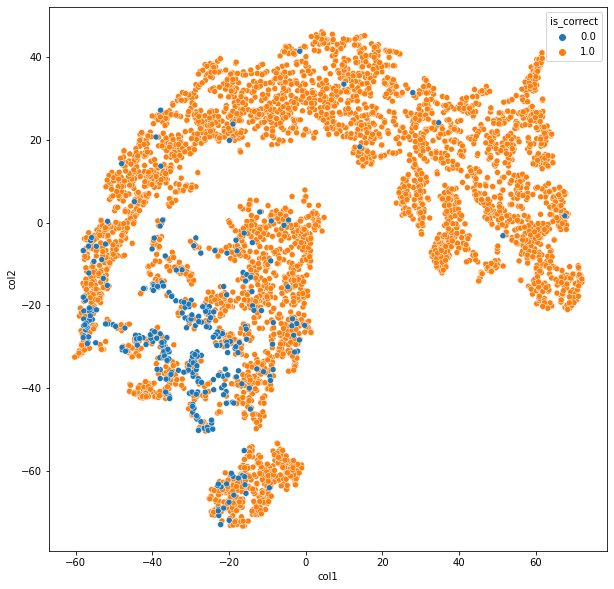

In [19]:
# Reducing dimensions into 2D using TSNE
from sklearn.manifold import TSNE

test_data = combined.values
X_embedded = TSNE(n_components=2, perplexity=50, n_iter=2000).fit_transform(test_data)

df1 = pd.DataFrame(np.hstack([X_embedded, labels.reshape(-1, 1)]), columns=['col1','col2','is_correct'])

plt.figure(figsize=(10, 10))
sns.scatterplot(x='col1', y='col2', hue='is_correct', data=df1)
plt.show()

## Observations
<ul> 
    <li> There are some overlaps with top 10 features for correct and wrong predictions. </li>
</ul>

### 6.6 Model trained on top 10 features evaluation

In [20]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [21]:
x_meta = generate_data(X_test, models)
y_test_pred = best_forest.predict(x_meta)
y_test_prob = best_forest.predict_proba(x_meta)

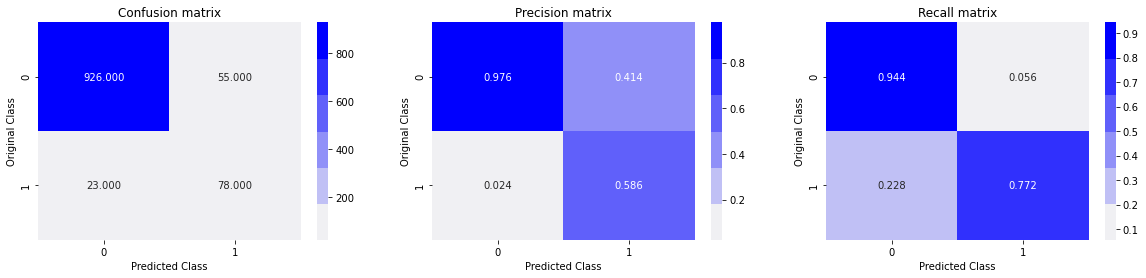

F1 score for test data:  0.6666666666666666
Recall for test data:  0.7722772277227723
Precision for test data:  0.5864661654135338


In [22]:
plot_confusion_matrix(y_test, y_test_pred)
print("F1 score for test data: ", f1_score(y_test, y_test_pred))
print("Recall for test data: ", recall_score(y_test, y_test_pred))
print("Precision for test data: ", precision_score(y_test, y_test_pred))

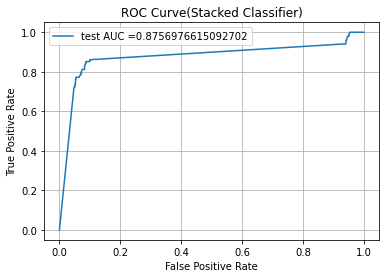

In [23]:
# AUC Score
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_prob[:, 1])

plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve(Stacked Classifier)")
plt.grid()
plt.show()

In [24]:
from prettytable import PrettyTable
tb = PrettyTable()
tb.field_names= ("Model Name", "False Negatives", "False Positives", "Recall", "Precision", "F1", "AUC")
tb.add_row(["LR+RandomForest(33 features)", 30, 43, 0.7030, 0.6228, 0.6605, 0.8845])
tb.add_row(["LR+RandomForest(top 10 features)", 23, 55, 0.7723, 0.5865, 0.6667, 0.8757])
print(tb)

+----------------------------------+-----------------+-----------------+--------+-----------+--------+--------+
|            Model Name            | False Negatives | False Positives | Recall | Precision |   F1   |  AUC   |
+----------------------------------+-----------------+-----------------+--------+-----------+--------+--------+
|   LR+RandomForest(33 features)   |        30       |        43       | 0.703  |   0.6228  | 0.6605 | 0.8845 |
| LR+RandomForest(top 10 features) |        23       |        55       | 0.7723 |   0.5865  | 0.6667 | 0.8757 |
+----------------------------------+-----------------+-----------------+--------+-----------+--------+--------+


## Observations
<ul> 
    <li> Modelling with top 10 features improves the recall score,F1 score with decrease in precision when compared to model with 33 features. </li>
</ul>

### 6.7 Saving model

In [25]:
# Saving all base models
for i in range(len(models)):
    dump(models[i], 'D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/base_learners2/base_model'+str(i)+'.joblib')
print("Saved all models!")

Saved all models!


In [26]:
# Saving model
dump(best_forest, 'D:/AI/Case_Studies/Personal_Case_Study_1/Saved_Models/best_custom_model2.joblib')
print("Model Saved successfully!")

Model Saved successfully!
